<a href="https://colab.research.google.com/github/juanigp/Pytorch-Deep-Dream/blob/master/Deep_Dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a pytorch version of the companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff).

The source code is from [github](https://github.com/juanigp/Pytorch-Deep-Dream/blob/master/Deep_Dream.ipynb) and [Pytorch Tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html).  
This notebook was generated for PyTorch==1.12.0 torchtext==0.13.0 cuda==11.7 windows.  

# Implementation of Deep Dream using Pytorch
## And some cool visualizations made with a pretrained VGG

### Requirements

In [1]:
import torch
import requests
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.models as models

from io import BytesIO
from torchvision import transforms
from PIL import Image, ImageFilter, ImageChops

### Implementing DeepDream in PyTorch

**Fetching the test image**

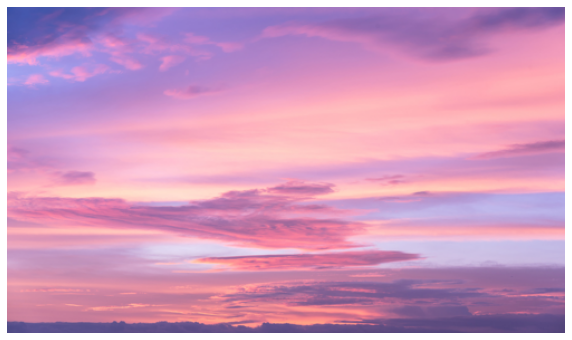

In [2]:
#Input image
url = 'https://s3.amazonaws.com/pbblogassets/uploads/2018/10/22074923/pink-sky-cover.jpg'
response = requests.get(url)
orig_img = Image.open(BytesIO(response.content))
orig_size = np.array(orig_img.size)
new_size = np.array(orig_img.size)*0.5
orig_img = orig_img.resize(new_size.astype(int))

fig = plt.figure(figsize = (10 , 10))
plt.axis("off")
plt.imshow(orig_img)

**Instantiating a pretrained `VGG19` model**

In [3]:
vgg = models.vgg19(pretrained = True)
vgg = vgg.cuda()
vgg.eval()

/home/e1_u2/.conda/envs/sandbox/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/e1_u2/.conda/envs/sandbox/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Basic idea: 

Get the output channels of a layer and compute the gradients from its L2 norm. Use this data to update the input image, but moving its parameters in the gradient direction (instead of against it). Repeat!

In [4]:
#Class to register a hook on the target layer (used to get the output channels of the layer)
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [5]:
#Function to make gradients calculations from the output channels of the target layer  
def get_gradients(net_in, net, layer):     
  net_in = net_in.unsqueeze(0).cuda()
  net_in.requires_grad = True
  net.zero_grad()
  hook = Hook(layer)
  net_out = net(net_in)
  loss = hook.output[0].norm()
  loss.backward()
  return net_in.grad.data.squeeze()

In [6]:
#denormalization image transform
denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
                              transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
                              ])

In [7]:
#Function to run the dream.
def dream(image, net, layer, iterations, lr):
  image_tensor = transforms.ToTensor()(image)
  image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor).cuda()
  for i in range(iterations):
    gradients = get_gradients(image_tensor, net, layer)
    image_tensor.data = image_tensor.data + lr * gradients.data
  img_out = image_tensor.detach().cpu()
  img_out = denorm(img_out)
  img_out_np = img_out.numpy().transpose(1,2,0)
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
  return img_out_pil

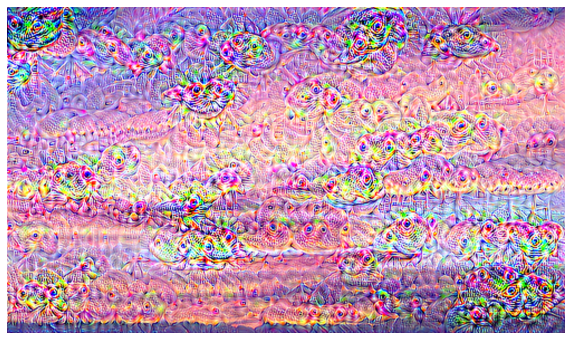

In [8]:
layer = list( vgg.features.modules() )[27]


img = dream(orig_img, vgg, layer, 20, 1)

img = img.resize(orig_size)
fig = plt.figure(figsize = (10 , 10))
plt.axis("off")
plt.imshow(img)

In [9]:
#Function to make gradients calculations from the output channels of the target layer.
#Selection of which output channels of the layer can be done
def get_gradients(net_in, net, layer, out_channels = None):     
  net_in = net_in.unsqueeze(0).cuda()
  net_in.requires_grad = True
  net.zero_grad()
  hook = Hook(layer)
  net_out = net(net_in)
  if out_channels == None:
    loss = hook.output[0].norm()
  else:
    loss = hook.output[0][out_channels].norm()
  loss.backward()
  return net_in.grad.data.squeeze()

#Function to run the dream. The excesive casts to and from numpy arrays is to make use of the np.roll() function.
#By rolling the image randomly everytime the gradients are computed, we prevent a tile effect artifact from appearing.
def dream(image, net, layer, iterations, lr, out_channels = None):
  image_numpy = np.array(image)
  image_tensor = transforms.ToTensor()(image_numpy)
  image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor).cuda()
  denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
                               ])
  for i in range(iterations):
    roll_x = np.random.randint(image_numpy.shape[0])
    roll_y = np.random.randint(image_numpy.shape[1])
    img_roll = np.roll(np.roll(image_tensor.detach().cpu().numpy().transpose(1,2,0), roll_y, 0), roll_x, 1)
    img_roll_tensor = torch.tensor(img_roll.transpose(2,0,1), dtype = torch.float)
    gradients_np = get_gradients(img_roll_tensor, net, layer, out_channels).detach().cpu().numpy()
    gradients_np = np.roll(np.roll(gradients_np, -roll_y, 1), -roll_x, 2)
    gradients_tensor = torch.tensor(gradients_np).cuda()
    image_tensor.data = image_tensor.data + lr * gradients_tensor.data

  img_out = image_tensor.detach().cpu()
  img_out = denorm(img_out)
  img_out_np = img_out.numpy()
  img_out_np = img_out_np.transpose(1,2,0)
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
  return img_out_pil

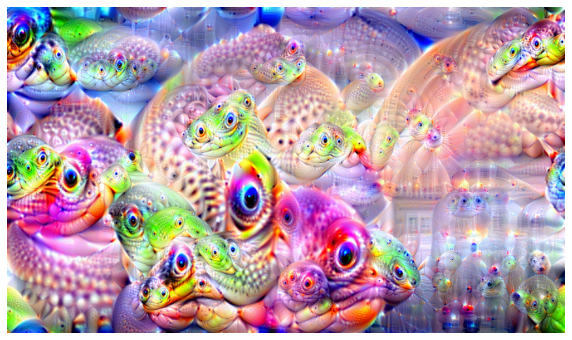

In [10]:
#To visualize features at different scales, the image is resized multiple times and run thru the dream
img = orig_img
OCTAVE_SCALE = 1.5
for n in range(-7,1):
  new_size = orig_size * (OCTAVE_SCALE**n)
  img = img.resize(new_size.astype(int), Image.ANTIALIAS)
  img = dream(img, vgg, layer, 50, 0.05, out_channels = None)

img = img.resize(orig_size)
fig = plt.figure(figsize = (10 , 10))
plt.axis("off")
plt.imshow(img)

## Implementation to guide the dream, using a target image with features we would like to visualize in our input image

In [29]:
def objective_guide(dst, guide_features):
    x = dst.data[0].cpu().numpy().copy()
    y = guide_features.data[0].cpu().numpy()
    ch, w, h = x.shape

    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    result = y[:,A.argmax(1)] # select ones that match best
    result = torch.Tensor(np.array([result.reshape(ch, w, h)], dtype=np.float64)).cuda()
    return result  

#Now we can have guide features as an input
def get_gradients(net_in, net, layer, control = False, guide_features = None):     
  net_in = net_in.unsqueeze(0).cuda()
  net_in.requires_grad = True
  net.zero_grad()
  hook = Hook(layer)
  net_out = net(net_in)
  if control:
    params = objective_guide(hook.output, guide_features)[0]
  else:
    params = hook.output[0]
  hook.output[0].backward( params )
  return net_in.grad.data.squeeze()      

def dream(image, net, layer, iterations, lr, control = False, guide_features = None):
  image_numpy = np.array(image)
  image_tensor = transforms.ToTensor()(image_numpy)
  image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor).cuda()
  denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
                               ])
  for i in range(iterations):
    roll_x = np.random.randint(image_numpy.shape[0])
    roll_y = np.random.randint(image_numpy.shape[1])
    img_roll = np.roll(np.roll(image_tensor.detach().cpu().numpy().transpose(1,2,0), roll_y, 0), roll_x, 1)
    img_roll_tensor = torch.tensor(img_roll.transpose(2,0,1), dtype = torch.float)
    gradients_np = get_gradients(img_roll_tensor, net, layer, control, guide_features).detach().cpu().numpy()
    gradients_np = np.roll(np.roll(gradients_np, -roll_y, 1), -roll_x, 2)
    ratio = np.abs(gradients_np.mean())
    lr_ = lr / ratio
    lr_ = lr
    gradients_tensor = torch.tensor(gradients_np).cuda()
    image_tensor.data = image_tensor.data + lr_ * gradients_tensor.data
  img_out = image_tensor.detach().cpu()
  img_out = denorm(img_out)
  img_out_np = img_out.numpy()
  img_out_np = img_out_np.transpose(1,2,0)
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
  return img_out_pil

In [33]:
layer = list( vgg.features.modules() )[33]

#extract target features
url_guide_features = "https://www.allfordogs.org/wp-content/uploads/2018/05/many-dog-faces.jpg"
response = requests.get(url_guide_features)
features_img = Image.open(BytesIO(response.content))
new_size = np.array(features_img.size)*1.5
features_img = features_img.resize(new_size.astype(int))

img_np = np.array(features_img)
img_tensor = transforms.ToTensor()(img_np)
hook = Hook(layer)
net_out = vgg(img_tensor.unsqueeze(0).cuda())
guide_features = hook.output

img = orig_img
OCTAVE_SCALE = 1.3
for n in range(-7,0):
  new_size = orig_size * (OCTAVE_SCALE**n)
  img = img.resize(new_size.astype(int), Image.ANTIALIAS)
  img = dream(img, vgg, layer, 50, 0.00005, control = True, guide_features = guide_features)

img = img.resize(orig_size)
fig = plt.figure(figsize = (10 , 10))
plt.axis("off")
plt.imshow(img)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.38 GiB. GPU 0 has a total capacty of 10.91 GiB of which 410.81 MiB is free. Process 29394 has 6.37 GiB memory in use. Including non-PyTorch memory, this process has 4.12 GiB memory in use. Of the allocated memory 3.77 GiB is allocated by PyTorch, and 167.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

메모리 부족으로 Batch size 조정 등이 필요한데 이 코드는 조절이 힘들다.

# Neural Style Transfer

### Requirements

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading the images
Download image from [picasso.jpg](https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg) and [dancing.jpg](https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg).

In [15]:
# desired size of the output image
imsize = 256 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./picasso.jpg")
content_img = image_loader("./dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

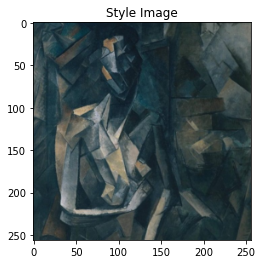

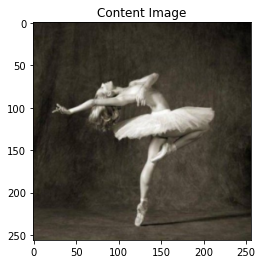

In [16]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

**Content loss**

In [17]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

**Style loss**

In [18]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [19]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

**Importing the model**

In [20]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).cuda().features.eval()

In [27]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).cuda()
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).cuda()

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [22]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

**Input Image**

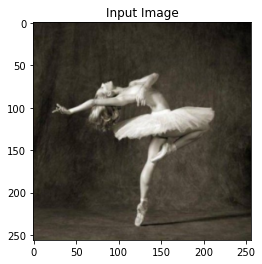

In [23]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

### Gradient Descent
we will use L-BFGS algorithm.

In [24]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [25]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

**Run the algorithm**

Building the style transfer model..
Optimizing..


/tmp/ipykernel_12201/400363304.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_12201/400363304.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 9.352527 Content Loss: 6.659538

run [100]:
Style Loss : 2.444268 Content Loss: 4.980009

run [150]:
Style Loss : 1.302137 Content Loss: 4.190606

run [200]:
Style Loss : 0.905071 Content Loss: 3.771614

run [250]:
Style Loss : 0.705225 Content Loss: 3.559512

run [300]:
Style Loss : 0.590575 Content Loss: 3.430537



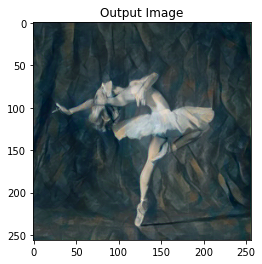

In [28]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

out of momory를 피하기 위해 size를 줄임